### Import Libraries

In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


### Define Configs

In [46]:
tickers = {
    'MSFT': {'ipo': '1986-03-13'},
    'AAPL': {'ipo': '1980-12-12'},
    'NVDA': {'ipo': '1999-01-22'},
    'AMZN': {'ipo': '1997-05-15'},
    'GOOG': {'ipo': '2004-08-19'},
    'META': {'ipo': '2012-05-18'},
    'TSLA': {'ipo': '2010-06-29'}
}

initial_capital = 1_000_000
commission = 0.001  # 0.10%
slippage = 0.0002  # 0.02%
min_shares = 10
risk_free_rate = 0.02
trading_days = 252  # Annual trading days
start_date = "1981-01-01"
end_date = "2023-12-31"
max_weight = 0.30  # Maximum 30% of AUM in any single stock


### Fetching data

In [36]:
def fetch_data(tickers):
    data = {}
    for ticker, details in tickers.items():
        ipo_date = details['ipo']
        print(f"Fetching data for {ticker} (IPO: {ipo_date})...")

        df = yf.download(ticker, start=ipo_date, end=end_date, auto_adjust=True)

        if df.empty:
            print(f"Warning: No data for {ticker}.")
            continue

        df['Ticker'] = ticker
        data[ticker] = df
    return data

data = fetch_data(tickers)


[*********************100%***********************]  1 of 1 completed

Fetching data for MSFT (IPO: 1986-03-13)...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for AAPL (IPO: 1980-12-12)...
Fetching data for NVDA (IPO: 1999-01-22)...
Fetching data for AMZN (IPO: 1997-05-15)...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for GOOG (IPO: 2004-08-19)...
Fetching data for META (IPO: 2012-05-18)...
Fetching data for TSLA (IPO: 2010-06-29)...


### RSI Strategy Signal & Position Reference

| Column      | Value           | Description                                                   |
|-------------|-----------------|---------------------------------------------------------------|
| `signal`    | `1`             | Entry signal to **go long** (RSI < entry threshold, e.g. 25)  |
|             | `-1`            | Entry signal to **go short** (RSI > short threshold, e.g. 75) |
|             | `-9`            | **Exit long** position (RSI > 50)                             |
|             | `9`             | **Exit short** position (RSI < 50)                            |
|             | `NaN`           | No signal on this date                                        |
| `positions` | `1`             | Holding a **long** position                                   |
|             | `-1`            | Holding a **short** position                                  |
|             | `0`             | **No position** / flat                                        |
| `side`      | `"long_entry"`  | Triggered a long trade entry                                  |
|             | `"short_entry"` | Triggered a short trade entry                                 |
|             | `"long_exit"`   | Exiting a long position                                       |
|             | `"short_exit"`  | Exiting a short position                                      |

In [37]:
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window, min_periods=1).mean()
    avg_loss = loss.rolling(window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [38]:
def get_rsi_signals(
    price_df: pd.DataFrame,
    lookback: int = 14,
    entry_rsi: int = 25,
    exit_rsi: int = 75,
    exit_threshold: int = 50  # default exit at rsi=50
) -> pd.DataFrame:
    """
    RSI signal generator using full price DataFrame (expects 'Close').
    Tracks position, signal, side, entry/exit dates.
    """

    close = price_df['Close']
    rsi = compute_rsi(close, lookback)

    # Initialize
    df = price_df.copy()
    df['rsi'] = rsi
    df['positions'] = 0
    df['signal'] = np.nan
    df['side'] = None

    in_position = 0  # 1 = long, -1 = short, 0 = flat

    for i in range(1, len(df)):
        rsi_now = df['rsi'].iloc[i]
        idx_now = df.index[i]

        if in_position == 0:
            if rsi_now < entry_rsi:
                if i + 1 < len(df):
                    df.loc[df.index[i + 1:], 'positions'] = 1
                df.loc[idx_now, ['signal', 'side']] = [1, 'long_entry']
                in_position = 1

            elif rsi_now > exit_rsi:
                if i + 1 < len(df):
                    df.loc[df.index[i + 1:], 'positions'] = -1
                df.loc[idx_now, ['signal', 'side']] = [-1, 'short_entry']
                in_position = -1

        elif in_position == 1 and rsi_now > exit_threshold:
            if i + 1 < len(df):
                df.loc[df.index[i + 1:], 'positions'] = 0
            df.loc[idx_now, ['signal', 'side']] = [-9, 'long_exit']
            in_position = 0

        elif in_position == -1 and rsi_now < exit_threshold:
            if i + 1 < len(df):
                df.loc[df.index[i + 1:], 'positions'] = 0
            df.loc[idx_now, ['signal', 'side']] = [9, 'short_exit']
            in_position = 0

    return df


## Test strategy on MSFT

In [39]:
data_msft = data['MSFT']
signal_df = get_rsi_signals(data_msft)

In [40]:
signal_df.head(10)

Price,Close,High,Low,Open,Volume,Ticker,rsi,positions,signal,side
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,,,,,
Date,,,,,,,,,,
1986-03-13,0.059707,0.062373,0.054376,0.054376,1031788800,MSFT,NaN,0,NaN,None
1986-03-14,0.061839,0.062906,0.059707,0.059707,308160000,MSFT,100.000000,0,-1.0,short_entry
1986-03-17,0.062906,0.063439,0.061839,0.061839,133171200,MSFT,100.000000,-1,NaN,None
1986-03-18,0.061306,0.063439,0.060773,0.062906,67766400,MSFT,66.662656,-1,NaN,None
1986-03-19,0.060240,0.061839,0.059707,0.061306,47894400,MSFT,54.544687,-1,NaN,None
1986-03-20,0.058641,0.060240,0.058108,0.060240,58435200,MSFT,42.858391,-1,9.0,short_exit
1986-03-21,0.057042,0.059707,0.055976,0.058641,59990400,MSFT,35.296248,0,NaN,None
1986-03-24,0.055442,0.057042,0.054909,0.057042,65289600,MSFT,30.002330,0,NaN,None


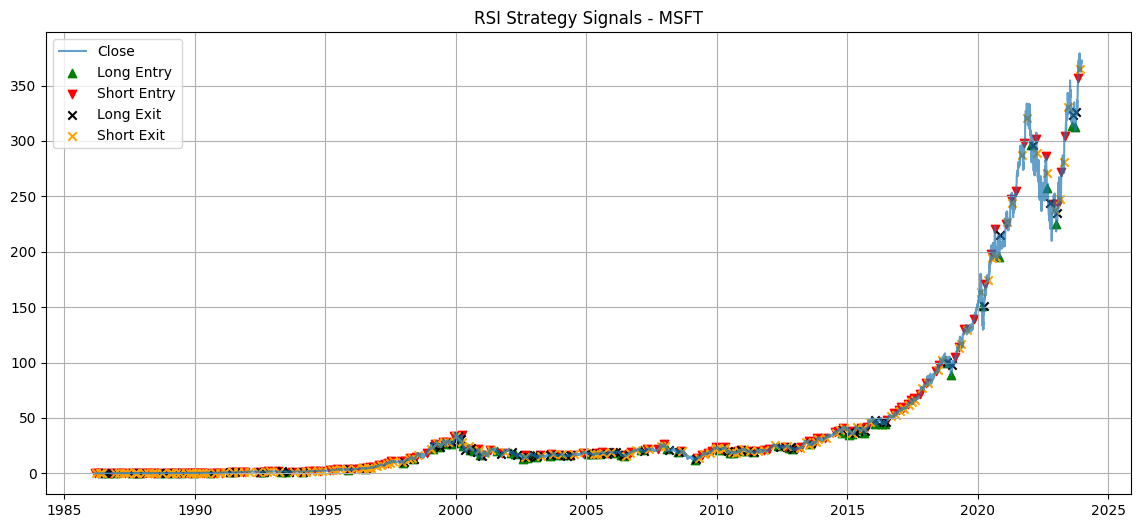

In [41]:
plt.figure(figsize=(14, 6))
plt.plot(signal_df['Close'], label="Close", alpha=0.7)

plt.scatter(signal_df.index[signal_df['side'] == 'long_entry'], 
            signal_df['Close'][signal_df['side'] == 'long_entry'],
            marker='^', color='green', label='Long Entry')

plt.scatter(signal_df.index[signal_df['side'] == 'short_entry'], 
            signal_df['Close'][signal_df['side'] == 'short_entry'],
            marker='v', color='red', label='Short Entry')

plt.scatter(signal_df.index[signal_df['side'] == 'long_exit'], 
            signal_df['Close'][signal_df['side'] == 'long_exit'],
            marker='x', color='black', label='Long Exit')

plt.scatter(signal_df.index[signal_df['side'] == 'short_exit'], 
            signal_df['Close'][signal_df['side'] == 'short_exit'],
            marker='x', color='orange', label='Short Exit')

plt.legend()
plt.title("RSI Strategy Signals - MSFT")
plt.grid()
plt.show()


# Construct Portfolio

In [43]:
signal_data = {}

for ticker, df in data.items():
    print(f"Generating signals for {ticker}")
    signal_data[ticker] = get_rsi_signals(df)
    
all_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # business days
portfolio_df = pd.DataFrame(index=all_dates)

for ticker, signals in signal_data.items():
    aligned = signals.reindex(all_dates)
    portfolio_df[ticker] = aligned['positions']


Generating signals for MSFT
Generating signals for AAPL
Generating signals for NVDA
Generating signals for AMZN
Generating signals for GOOG
Generating signals for META
Generating signals for TSLA


In [44]:
portfolio_df

,MSFT,AAPL,NVDA,AMZN,GOOG,META,TSLA
1981-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-02,NaN,-1.0,NaN,NaN,NaN,NaN,NaN
1981-01-05,NaN,-1.0,NaN,NaN,NaN,NaN,NaN
1981-01-06,NaN,-1.0,NaN,NaN,NaN,NaN,NaN
1981-01-07,NaN,-1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-26,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0
2023-12-27,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
2023-12-28,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
